# YOLO and COCO object recognition basics in Python

By [Mikolaj Buchwald (LI profile)](https://www.linkedin.com/in/mikolaj-buchwald/) -- [mikbuch's GitHub](github.com/mikbuch)

This tutorial is an adaptation of [the example](https://opencv-tutorial.readthedocs.io/en/latest/yolo/yolo.html) explained in the official OpenCV YOLO documentation. The reason for creating this Notebook is that I myself had difficulties recreating this example based on the aforementioned documentation. That is why I created this step-by-step Notebook when you can re-run all cells and get to know YOLO and coco better.

## YOLO -- an object detection network

> _YOLO — You Only Look Once — is an extremely fast multi object detection algorithm which uses convolutional neural network (CNN) to detect and identify objects._
>
> _The neural network has this network architecture._
>
> ![YOLO network archtecture](yolo1_net.png)
>
> Source: https://arxiv.org/pdf/1506.02640.pdf

I quote this explanation from: [OpenCV YOLO tutorial](https://opencv-tutorial.readthedocs.io/en/latest/yolo/yolo.html)


## COCO -- class labels for 80 objects

The class names are stored in the `coco.names` text file:

In [1]:
!cat coco.names | wc -l

80


In [2]:
!cat coco.names | head

person
bicycle
car
motorcycle
airplane
bus
train
truck
boat
traffic light


## Troubleshooting/important notes

### High resolution images

Note, in order to use the code from this notebook with larger resolution images, you will have to adjust border width and font size in the cells below, else the borders will be very thin, almost unvisible on the final rendered picture, and the font size will be extremely small.

### `net.getUnconnectedOutLayers()` vector or matrix

It seems that, depending on the (OpenCV?) implementation, the `net.getUnconnectedOutLayers()` can be either a vector or a matrix. This problem is dealt with in this Notebook by `try`-`except` clause, but pay attention to that in your own use cases.


## Import prerequisites

As a matter of fact, we will need OpenCV for Python in this example (i.e., `cv2`). It is usually (by convention) imported like that: `import cv2`.

In [3]:
import cv2
import numpy as np
import os
import time

from matplotlib import pyplot as plt

## Example image

OpenCV tutorial example image: https://opencv-tutorial.readthedocs.io/en/latest/_images/horse.jpg.  

In [4]:
img_name = 'horse.jpg'

# Reading image to an object (we will display it in the next step).
img = cv2.imread(img_name) 

### Color conversion while displaying the image

Matplotlib interprets images in RGB format, but OpenCV uses BGR format

So to convert the image so that it's properly loaded, convert it before loading (for details, see: https://www.codegrepper.com/code-examples/python/imshow+wrong+colors).

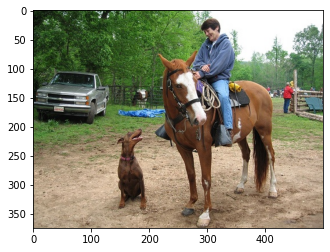

In [5]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

> _Load the YOLO network_
> 
> _In order to run the network you will have to download the pre-trained YOLO weight file (237 MB). https://pjreddie.com/media/files/yolov3.weights_
> 
> _Also download the the YOLO configuration file._
> 
> _[yolov3.cfg](https://opencv-tutorial.readthedocs.io/en/latest/_downloads/10e685aad953495a95c17bfecd1649e5/yolov3.cfg)_

Source: https://opencv-tutorial.readthedocs.io/en/latest/yolo/yolo.html#load-the-yolo-network

#### Downloading the `yolov3.weights` file

The `yolov3.weights` file is pretty large, hence I couldn't include it in the reporitory with this example. We will have to make sure that this file is available for you -- by downloading the file:

In [6]:
!wget -O yolov3.weights https://pjreddie.com/media/files/yolov3.weights

--2022-07-09 17:59:45--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  1.82MB/s    in 2m 7s   

2022-07-09 18:01:53 (1.86 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [7]:
# Load names of classes and get random colors for them.
classes = open('coco.names').read().strip().split('\n')
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')

# Give the configuration and weight files for the model and load the network.
net = cv2.dnn.readNetFromDarknet('yolov3.cfg', 'yolov3.weights')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
#net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Show the network object
net

<dnn_Net 0x7f60eb663450>

## Determine the output layer

In [8]:
# First, get layer names
ln = net.getLayerNames()
len(ln)

254

In [9]:
# Show names of all layers
print(ln)

('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_37', 'bn_37', 'leaky_

In [10]:
# Get output layers
net.getUnconnectedOutLayers()

array([200, 227, 254], dtype=int32)

It seems that, depending on the (OpenCV?) implementation, the `net.getUnconnectedOutLayers()` can be either a vector or a matrix. This problem is dealt with in this Notebook by `try`-`except` clause, but pay attention to that in your own use cases.

In [11]:
# Show the names of this layers
try:
    print([ln[i[0] - 1] for i in net.getUnconnectedOutLayers()])
except IndexError:
    print([ln[i - 1] for i in net.getUnconnectedOutLayers()])

['yolo_82', 'yolo_94', 'yolo_106']


In [12]:
# Use this layers
try:
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
except IndexError:
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

ln

['yolo_82', 'yolo_94', 'yolo_106']

Blob is an input to the YOLO network.

Blob shape=(1, 3, 416, 416)


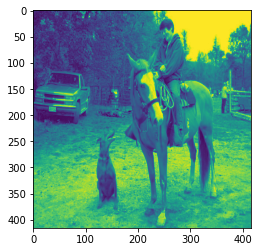

In [13]:
# Construct a blob from the image
blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
r = blob[0, 0, :, :]

plt.imshow(r)
print('Blob shape=%s' % (blob.shape,))

In [14]:
net.setInput(blob)
t0 = time.time()
outputs = net.forward(ln)
t = time.time()
print('It took %.3f seconds to process the image.' % (t-t0))

It took 0.525 seconds to process the image.


The outputs object are vectors of lenght 85 (4 + 1 + 80):

    4x the bounding box (centerx, centery, width, height)
    1x box confidence
    80x class confidence


In [15]:
print('Found %s objects.' % len(outputs))

print('\nEnlisting objects:')
print([out.shape for out in outputs])

Found 3 objects.

Enlisting objects:
[(507, 85), (2028, 85), (8112, 85)]


Image preview:


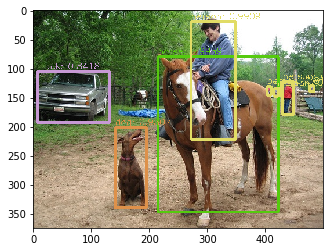

In [16]:
boxes = []
confidences = []
classIDs = []
h, w = img.shape[:2]

for output in outputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > 0.5:
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)

indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in colors[classIDs[i]]]
        
        #  -- Arguments for CV2 rectangle:
        # cv2.rect   (img,  x, y,   width, height, color, line width)
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 4)
        
        # Labels and confidences for the image
        text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
        cv2.putText(img, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

print('Image preview:')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation='none')

## Write image to the output file

In [17]:
cv2.imwrite('output.png', img)

True

## Show image with bounding boxes

### Color conversion

Matplotlib interprets images in RGB format, but OpenCV uses BGR format. So to convert the image so that it's properly loaded, convert it before loading (for details, see: https://www.codegrepper.com/code-examples/python/imshow+wrong+colors)

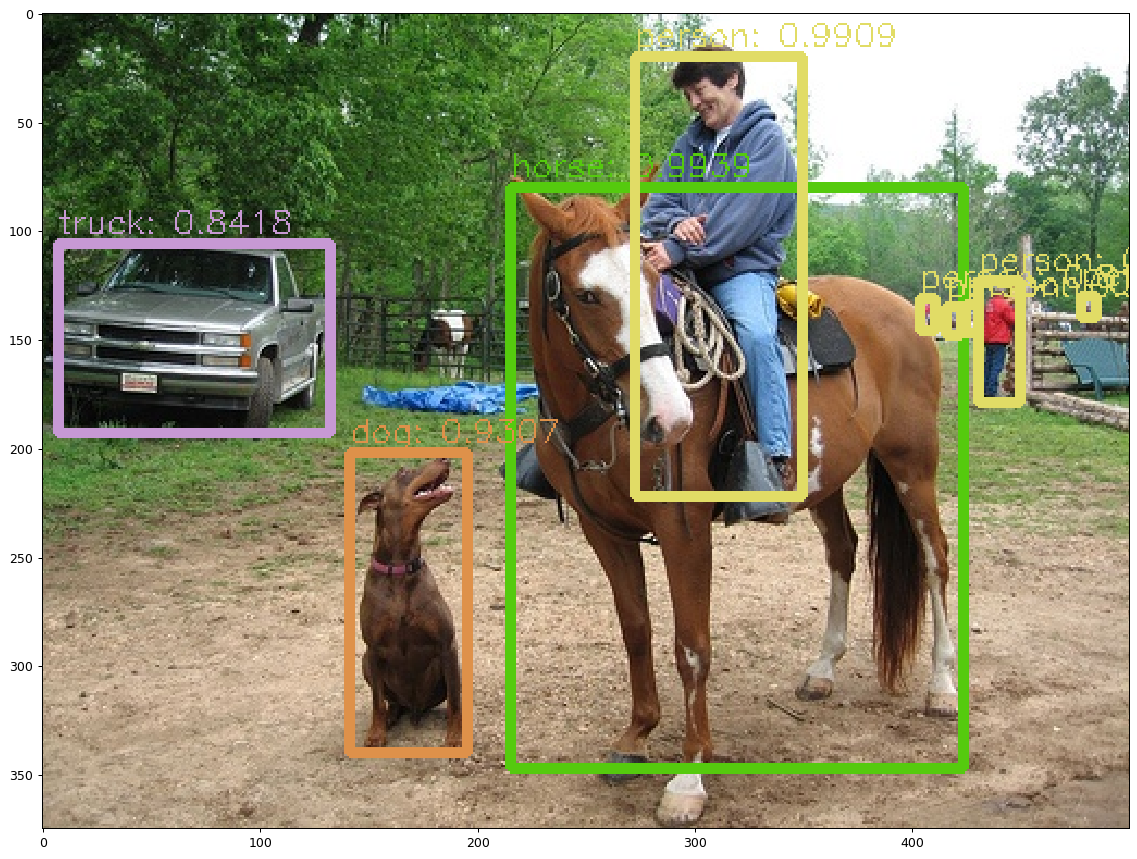

In [18]:
fig, ax = plt.subplots(figsize=(20, 12), dpi=90)
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation='none')